# Heron Island 19JUN18 Sentinel 2a overpass workflow

### General setup

In [1]:
import time, sys, os, shutil
start_time = time.time()

from datetime import datetime, timedelta

import pandas as pd
import numpy as np

sys.path.append("..")
from CalVal import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['savefig.dpi'] = 300


field_data = ['HER', '19JUN18', '', 'Sentinel2a', '', '', '']
indir='/g/data/u46/users/aw3463/GuyByrne/30APR18/Heron/12JUN18/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/HER-12JUN18-S2a/'
fignum=1

directory = os.path.dirname(output)
if os.path.exists(directory):
    shutil.rmtree(directory)
os.makedirs(directory)

    
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 1.0, 0.0, 0.0],
                          ['band11', 1.0, 0.0, 0.0],
                          ['band12', 1.0, 0.0, 0.0],
                          ['band2', 1.0, 0.0, 0.0],
                          ['band3', 1.0, 0.0, 0.0],
                          ['band4', 1.0, 0.0, 0.0],
                          ['band5', 1.0, 0.0, 0.0],
                          ['band6', 1.0, 0.0, 0.0],
                          ['band7', 1.0, 0.0, 0.0],
                          ['band8', 1.0, 0.0, 0.0],
                          ['band8a', 1.0, 0.0, 0.0],
                         ])
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = True
StartCorner = 'SE'

## IMPORTANT NOTE
Original csv file has three spreadsheets with incorrect labels. 
The following is the mapping from original labels to the currently used labels in this workflow.<P>

<TABLE>
<TR>

<TD>Original Label</TD><TD>Device ID</TD><TD>Device Description</TD><TD>Name Used in this Workflow</TD></TR>
<TR><TD>ed</TD><TD>8494</TD><TD>Scalar Irradiance - spherical</TD><TD>Lu</TD></TR>
<TR><TD>ed Total</TD><TD>8035</TD><TD>Irradiance - cosine</TD><TD>Ed</TD></TR>
<TR><TD>lu</TD><TD>81f7</TD><TD>Radiance - 7$^\circ$ FOV</TD><TD>Lsky</TD></TR>
</TABLE>



### Read in Lu, set Wavelength to be index and drop bad spectra

In [2]:
Lu = pd.read_csv(indir+'HP1.csv')
Lu.set_index('Time', inplace=True)
Lu.index.names = ['Wavelength']
Lu.drop('576.23333', axis=1, inplace=True)
Lu.drop('579.71667', axis=1, inplace=True)

### Plot Lu spectra

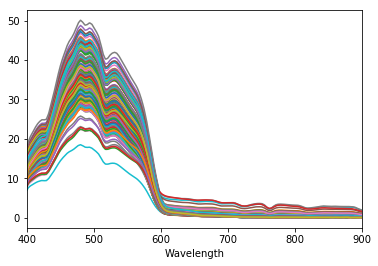

In [3]:
Lu.plot(legend=False)
plt.savefig(output+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_FIG'+str(fignum)+'_Lu.png')
fignum+=1

### Read in Ed and set Wavelength as index

In [4]:
Ed = pd.read_csv(indir+'HP2.csv')
Ed.set_index('Time', inplace=True)
Ed.index.names = ['Wavelength']

### Plot Ed

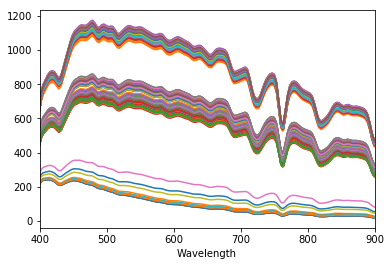

In [5]:
Ed.plot(legend=False)

### Remove any spectra from Ed where the first channel is NOT between 400-600
### Plot the result

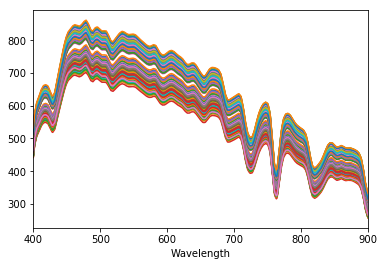

In [6]:
badcols = []

for i in range(len(Ed.iloc[0])):
    if Ed.iloc[0,i]>600 or Ed.iloc[0,i]<400:
        badcols.append(i)
        
Ed.drop(Ed.columns[badcols], axis=1, inplace=True)

Ed.plot(legend=False)
plt.savefig(output+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_FIG'+str(fignum)+'_Ed.png')
fignum+=1

### Read in Lsky and set index to Wavelength

In [7]:
Lsky = pd.read_csv(indir+'HP3.csv')
Lsky.set_index('Time', inplace=True)
Lsky.index.names = ['Wavelength']

### Remove bad spectra from Lsky (anything where first channel is below 200)
### Plot the result

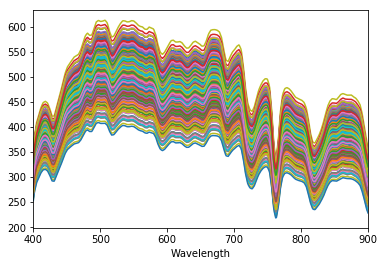

In [8]:
badcols = []

for i in range(len(Lsky.iloc[0])):
    if Lsky.iloc[0,i]<200:
        badcols.append(i)
        
Lsky.drop(Lsky.columns[badcols], axis=1, inplace=True)

Lsky.plot(legend=False)
plt.savefig(output+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_FIG'+str(fignum)+'_Lsky.png')
fignum+=1

### Convert times for columns to seconds

In [9]:
res_Lu = [int(60*x) for x in Lu.columns.values.astype(float)]
res_Ed = [int(60*x) for x in Ed.columns.values.astype(float)]
res_Lsky = [int(60*x) for x in Lsky.columns.values.astype(float)]

In [10]:
## NOT USED
#res12 = [a_i - b_i for a_i, b_i in zip(res_Lu, res_Ed)]
#res13 = [a_i - b_i for a_i, b_i in zip(res_Lu, res_Lsky)]
#res23 = [a_i - b_i for a_i, b_i in zip(res_Ed, res_Lsky)]


### Relabel column names to time in seconds (since midnight)

In [11]:
Ed.columns = res_Ed
Lsky.columns = res_Lsky
Lu.columns = res_Lu

### Match up columns within 2 seconds of each other (just for Ed and Lu)

In [12]:
Edplus = Ed.copy()
Edplus.columns = Ed.columns.values+1
Edminus = Ed.copy()
Edminus.columns = Ed.columns.values-1

Luplus = Lu.copy()
Luplus.columns = Lu.columns.values+1
Luminus = Lu.copy()
Luminus.columns = Lu.columns.values-1

### Define refl_df - DataFrame with reflectances

Formula used to create refl_df is <P>
    $\pi \times (L_u - \rho \times L_{sky})/E_d$<P>
    
with $\rho=0$, such that Lsky is not needed.<BR>
Due to the potential mimatch in timestamps (of up to 1 second) between spectra,
the following method is used to re-align spectra in time:<BR>
First see if times align, <BR>if not, see if there is Lu spectrum 1 second before Ed spectrum.<BR>
If not, see if there is Lu spectrum 1 second after Ed spectrum.</P>

This should align all spectra.

In [13]:
### Use this cell for (Lu - rho*Lsky)/Ed, (with rho=0)

refl_df = pd.DataFrame()
for i in Lsky.columns.values:
    try:
        refl_df = pd.concat([refl_df, ((Lu[i]*np.pi))/Ed[i]], axis=1)
    except KeyError:
        try:
            refl_df = pd.concat([refl_df, ((Luplus[i]*np.pi))/Ed[i]], axis=1)
        except KeyError:
            try:
                refl_df = pd.concat([refl_df, ((Luminus[i]*np.pi))/Ed[i]], axis=1)
            except KeyError:
                continue
            continue
        continue
        
#badcols = []

#for i in range(len(plop.iloc[0])):
#    if plop.iloc[0,i]>0.08:
#        badcols.append(i)
        
#plop.drop(plop.columns[badcols], axis=1, inplace=True)

### Extend ends of spectra (at 400 and 900nm) out to 350-2500nm.
This allows matching with satellite bands to behave nicely.<BR>
But note that there is no real data outside 400-900nm.

In [14]:
for i in range(901, 2501):
    refl_df.loc[i] = refl_df.loc[900]
for i in range(350, 399):
    refl_df.loc[i] = refl_df.loc[400]

### Define median of all reflectances and plot

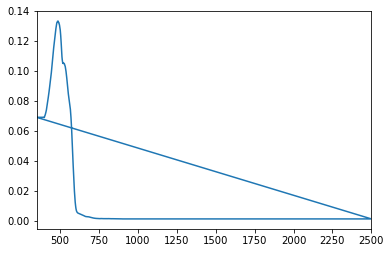

In [15]:
median = refl_df.median(axis=1)
median.plot()

### Drop spectra with no GPS
Since the GPS was only turned on during the second transect, 
drop all spectra without a corresponding GPS signal.<BR>
This happens at time 35133 seconds.<P>

These spectra are dropped because we know that at least some of the earlier spectra
were taken at a different location to the field site.

In [16]:
for i in refl_df.columns:
    if int(i)<35133:
        refl_df.drop(i, axis=1, inplace=True)
    

### Apply satellite band weights
Convole the spectra into the satellite bands and produce both Landsat and Sentinel band DataFrames

In [17]:
ls_result_df, s2_result_df, ls_band, s2_band = ApplyWeights.apply_weights(f_name, refl_df, sat_resp, field_data)

### Add columns to dataframes
Manually add latitude, longitude and timestamp to Landsat and Sentinel DataFrames

In [18]:
ls_result_df['Latitude'] = -23.435776 
ls_result_df['Longitude'] = 151.998163
ls_result_df['Line'] = 1
ls_result_df['date_saved'] = datetime(2018, 6, 19, 23, 45, 34)

s2_result_df['Latitude'] = -23.435776 
s2_result_df['Longitude'] = 151.998163
s2_result_df['Line'] = 1
s2_result_df['date_saved'] = datetime(2018, 6, 19, 23, 45, 34)

### Read in GPS data
Based on the file "ff2.txt", which lists lat,lon and timestamps, apply GPS coordinates to the data where there is an overlap in time. For any spectrum, this updates the coordinates with all GPS entries until
the time for the GPS entry is greater than the time for the spectrum. This way, the closest GPS coordinate in time is chosen, but doen't necessarily have to overlap in time.

In [19]:
gps_data = pd.read_csv(indir+'ff2.txt')
gps_data.set_index('time', inplace=True)

for i in range(len(refl_df.columns.values)-1):
    for j in range(len(gps_data.index)):
        if refl_df.columns.values[i] <= gps_data.index[j]:
            ls_result_df['Latitude'][i] = gps_data.latitude.iloc[j]
            ls_result_df['Longitude'][i] = gps_data.longitude.iloc[j]
            s2_result_df['Latitude'][i] = gps_data.latitude.iloc[j]
            s2_result_df['Longitude'][i] = gps_data.longitude.iloc[j]
            break
    if refl_df.columns.values[i] > gps_data.index[-1]:
        ls_result_df['Latitude'][i] = gps_data.latitude.iloc[-1]
        ls_result_df['Longitude'][i] = gps_data.longitude.iloc[-1]
        s2_result_df['Latitude'][i] = gps_data.latitude.iloc[-1]
        s2_result_df['Longitude'][i] = gps_data.longitude.iloc[-1]

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/g/data/v10/public/mod

### Add column to dataframes that lists the Solar zenith angle, based on lat, long and time.

In [20]:
from CalVal.SolarAngle import solang
ls_result_df['Solar_angle'] = ls_result_df.apply(solang, axis=1)
s2_result_df['Solar_angle'] = s2_result_df.apply(solang, axis=1)

### Determine BRDF parameters
This should not be needed over a marine environment, but is included in case of compatibility in the future.

In [21]:
PrintBRDF.print_brdf(ls_result_df, field_data)

#################################################################################
# Copy and paste the following into a terminal window on VDI for Landsat 8 data #
#################################################################################

source module_C5.sh
sed -i "40s/.*/        self.acquisition_datetime = dateutil.parser.parse('2018-06-19 23:45:34')/" retrieve_brdf_C5.py
sed -i "43s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(151.998163, -23.4380563, 151.99998530000002, -23.435776)]})/" retrieve_brdf_C5.py
python retrieve_brdf_C5.py > temp.txt ; awk -f format_Sent.awk temp.txt



### Apply BRDF corrections
At the moment, the BRDF parameters are set so that no correction is applied.<BR>
This is kept in for possible future compatibility.

In [22]:
ls_ground_brdf, s2_ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ls_result_df, s2_result_df, field_data)

### Determine wavelength extents of satellite bands

In [23]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

### Plot median spectrum, with band wavelength ranges
Note: Only bands 1-7 (Sentinel) are relevant because the ramses only collects between 400-900 nm.

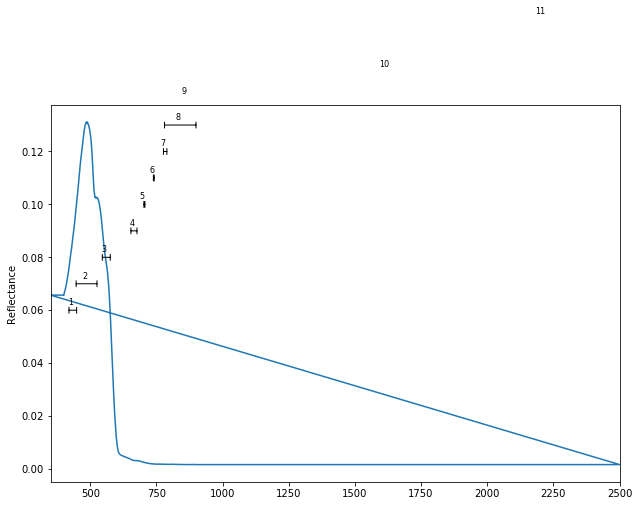

In [24]:
FIG_BandExtents.FIG_band_extents(refl_df, band_min, band_max, output, field_data, fignum)
fignum += 1

### Retrieve satellite data from Datacube

In [25]:
ls_sat_array, ls_sat_bigarray, s2_sat_array, s2_sat_bigarray, ls8_usgs_array, ls8_usgs_bigarray, solar_zenith,\
ls_query, s2_query, ls_dc, s2_dc, ls_ground_WSbrdf = QueryAndCreate.query_and_create(ls_ground_brdf, s2_ground_brdf, ls_result_df, s2_result_df, field_data, Corners, RockWalk, StartCorner)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series

Assuming good GPS Coordinates, continuing...


### Location comparison of field and satellite data
Field data locations are shown as coloured dots.<BR>
Satellite pixels are shown as the squares, with the centre of each pixel shown by a black dot.

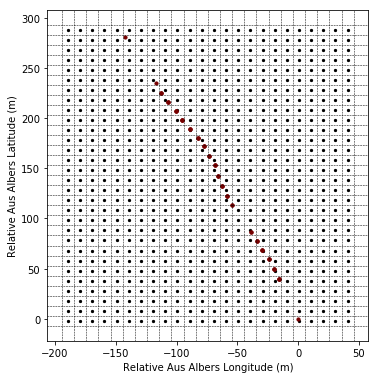

In [26]:
ls_xloc, s2_xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ls_ground_brdf, s2_ground_brdf, ls_sat_array, s2_sat_array, colpac, output, field_data, fignum)
fignum +=1

### Create field data array, based on satellite pixels
Use the satellite pixel locations to create an array with the same locations for each pixel.<BR>
The values in each pixel are the average value of field data that overlap in position with that pixel.<BR>
If there are no overlapping field data points, then the pixel remains blank.<BR>

In [27]:
ls_field_array, s2_field_array = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)
ls_field_WSarray, dummy = CreateFieldFromSat.create_field_from_sat(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, ls_xloc, s2_xloc, field_data)

### Plot large-area RGB image of satellite data
Used to assess the context for the field site. This plot is approximately 2 km on each side 
(technically 0.02$^\circ$). The B/W square in the middle represents the location of the field
site. But note that the field site may be oriented at an angle to North, which is not represented here.

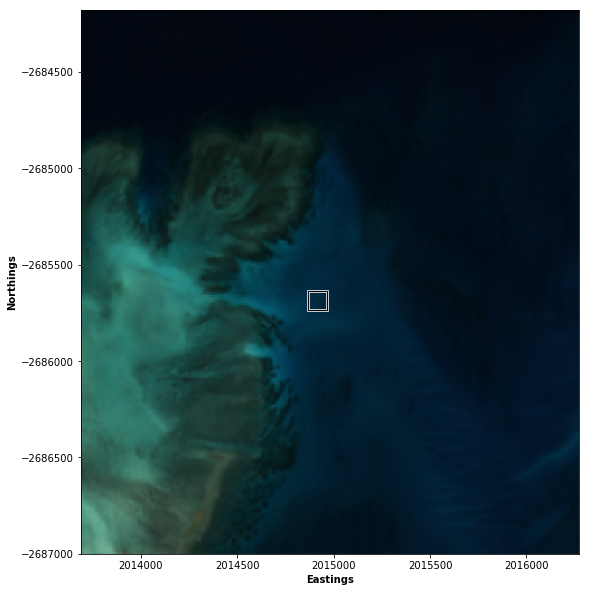

In [28]:
if field_data[3] == 'Landsat8':
    FIG_SatBigRGB.FIG_sat_bigRGB(ls_sat_array, ls_sat_bigarray, output, field_data, fignum)
else:
    FIG_SatBigRGB.FIG_sat_bigRGB(s2_sat_array, s2_sat_bigarray, output, field_data, fignum)
fignum += 1

### Plot satellite RGB image
This RGB image contains only the satellite pixels corresponding to the field site area, plus a buffer of typically 1-2 pixels.

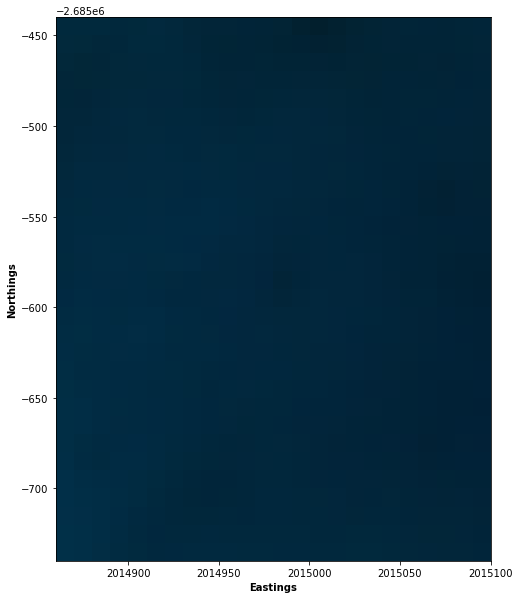

In [29]:
if field_data[3] == 'Landsat8':
    FIG_SatRGB.FIG_sat_RGB(ls_sat_array, output, field_data, fignum)
else:
    FIG_SatRGB.FIG_sat_RGB(s2_sat_array, output, field_data, fignum)
fignum += 1

### Field date RGB image
This plot shows the RGB image for the field data pixels. Blank pixel (where there is not field data) are shown as black.
The pixels correspond exactly to the previous image.

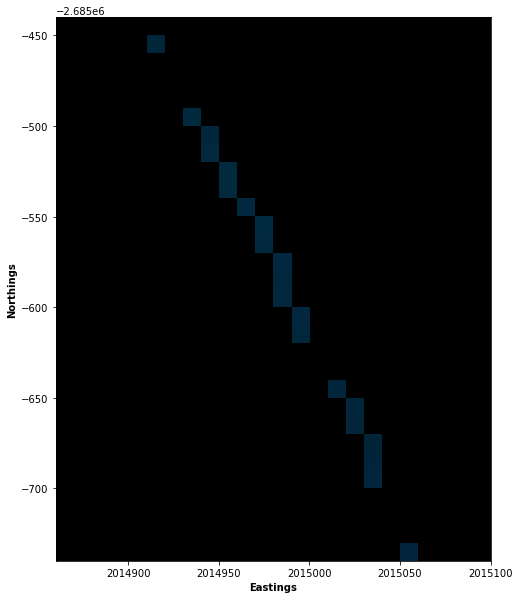

In [30]:
if field_data[3] == 'Landsat8':
    FIG_FieldRGB.FIG_field_RGB(ls_field_WSarray, output, field_data, fignum)
else:
    FIG_FieldRGB.FIG_field_RGB(s2_field_array, output, field_data, fignum)
fignum += 1

### Plot of location stability of field site
Satellite data over the field site are plotted for each band. 
Data in each band have been normalised to the average value for that band, 
so relative intensities are shown. 
A perfectly flat field site will show a uniform green colour, corresponding to 1.0 intensity scale.
A non-uniform field site will show more yellows and blues.

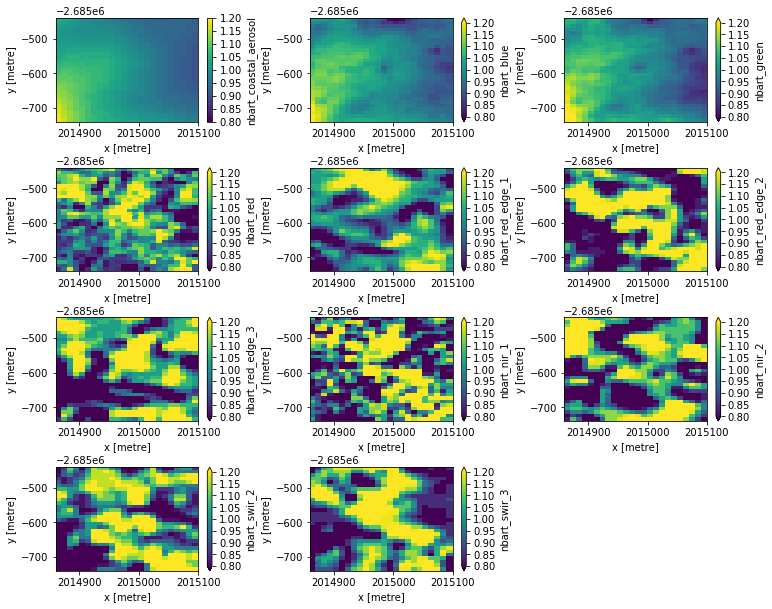

In [31]:
if field_data[3] == 'Landsat8':
    variance = FIG_SatBands.FIG_sat_bands(ls_sat_array, ls_field_WSarray, output, field_data, fignum)
else:
    variance = FIG_SatBands.FIG_sat_bands(s2_sat_array, s2_field_array, output, field_data, fignum)
fignum += 1

### Ratio plot of field/satellite pixels
For the overlapping pixels between field and satellite data, how the ratio, 
such that a perfect agreement between field and satellite will show a green colour, with intensity 1.0.

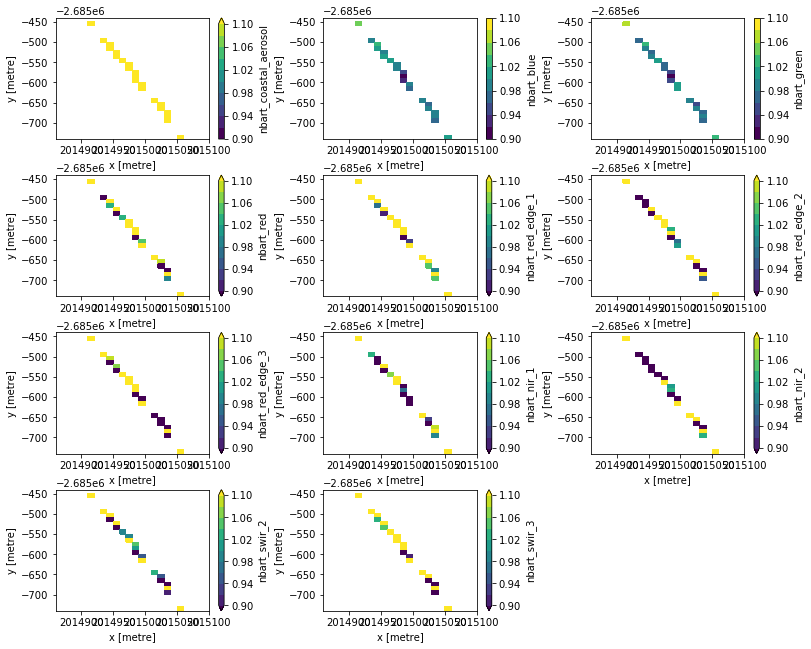

In [32]:
if field_data[3] == 'Landsat8':
    FIG_RatioArrays.FIG_ratio_arrays(ls_sat_array, ls_field_WSarray, output, field_data, fignum)
else:
    FIG_RatioArrays.FIG_ratio_arrays(s2_sat_array, s2_field_array, output, field_data, fignum)
fignum += 1

### Create statistic summary DataFrames

In [33]:
ls_fstat_df, s2_fstat_df = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
ls_fstat_WSdf, dummy = CreateStats.create_stats(ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, field_data)

if field_data[6] == 'USGS':
    ls_fstat_usgs_df, dummy = CreateStats.create_stats(ls8_usgs_array, s2_sat_array, ls_ground_brdf, s2_ground_brdf, field_data)
else:
    ls_fstat_usgs_df = 0

### Create statistic sunmmary DataFrames, using only those pixels overlapping with field data locations

In [34]:
ls_finner_df, s2_finner_df = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_array, s2_field_array, ls_ground_brdf, s2_ground_brdf, ls_fstat_df, s2_fstat_df, field_data)
ls_finner_WSdf, dummy = CreateSubStats.create_SUB_stats(ls_sat_array, s2_sat_array, ls_field_WSarray, s2_field_array, ls_ground_WSbrdf, s2_ground_brdf, ls_fstat_WSdf, s2_fstat_df, field_data)

### Plot band spectra
This plot compares band spectra for both field and satellite data.<BR>
Field data average is shown in blue. Satellite averages are shown in black and orange.<BR>
The difference between black and orange satellite lines is that the black line includes all the
satellite pixels over the field site, plus any buffer pixels. The orange line includes only those 
satellite pixels that overlap with at least one field spectrum location.

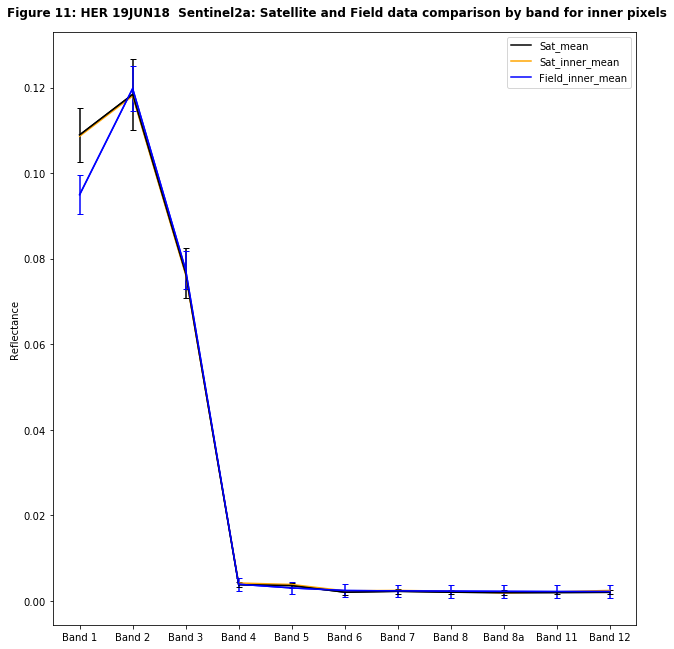

In [35]:
if field_data[3] == 'Landsat8':
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, output, field_data, fignum)
else:
    FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(s2_sat_array, s2_fstat_df, s2_finner_df, output, field_data, fignum)
fignum += 1

### Printable version of previous plot
Only the satellite data that includes all pixels over the field site (plus buffer) is shown in blue.
Field data shown in red.

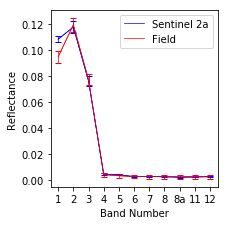

In [36]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldBands.FIG_sat_field_bands(ls_sat_array, ls_fstat_WSdf, ls_finner_WSdf, output, field_data, fignum)
else:
    FIG_SatFieldBands.FIG_sat_field_bands(s2_sat_array, s2_fstat_df, s2_finner_df, output, field_data, fignum)
fignum += 1

### Comparison plot of field and satellite data on pixel-by-pixel basis
Data from each band are shown with different colours and different symbols.
The diagonal line represents equality between field and satellite points, so that ideally all points
should lie along this line.

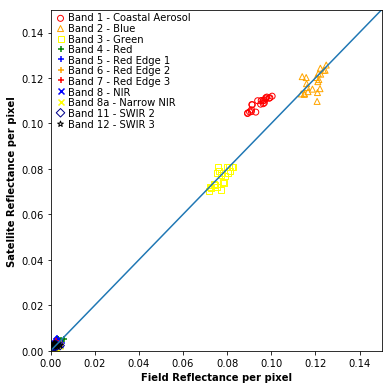

In [37]:
plot_scale = [0.0, 0.15, 0.0, 0.15]
if field_data[3] == 'Landsat8':
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(ls_sat_array, ls_field_WSarray, plot_scale, output, field_data, fignum)
else:
    FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(s2_sat_array, s2_field_array, plot_scale, output, field_data, fignum)
fignum += 1

### Plot average comparison of field and satellite data
Error bars are 1$\sigma$ uncertainties, based on the pixel-by-pixel variability.

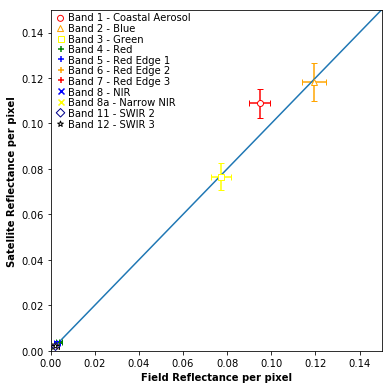

In [38]:
if field_data[3] == 'Landsat8':
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(ls_sat_array, ls_field_WSarray, plot_scale, ls_fstat_WSdf, output, field_data, fignum)
else:
    FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(s2_sat_array, s2_field_array, plot_scale, s2_fstat_df, output, field_data, fignum)
fignum += 1

### Print out data summary sheet

In [39]:
indir = ''
if field_data[3] == 'Landsat8':
    PrintSheet.print_sheet(ls_ground_WSbrdf, ls_sat_array, ls_fstat_WSdf, indir, output, field_data, Corners, RockWalk, StartCorner, variance, ls_query, ls_dc)
else:
    PrintSheet.print_sheet(s2_ground_brdf, s2_sat_array, s2_fstat_df, indir, output, field_data, Corners, RockWalk, StartCorner, variance, s2_query, s2_dc)

### Write out csv files with summary comparison data

In [40]:
OutputCSVs.output_csvs(ls_fstat_WSdf, ls_fstat_usgs_df, s2_fstat_df, ls_sat_array, s2_sat_array, ls_ground_WSbrdf, s2_ground_brdf, field_data)

Difference in time between field site measurement and Sentinel data is -1 days +00:17:07.024000


In [41]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

This Notebook took  0:04:54 (h:m:s) to run
